In [1]:
from fastai.text import *
import html
import pandas as pd

/root/py36venv/lib64/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load INSPIRE data

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('inspire_data/')

In [3]:
CLAS_PATH=Path('inspire_data/inspire_clas')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('inspire_data/inspire_lm/')
LM_PATH.mkdir(exist_ok=True)

In [4]:
inspire_data = pd.read_pickle('inspire_data/combined_data.df')

inspire_data = inspire_data.sample(frac=1).reset_index(drop=True)
inspire_data.columns = ['text', 'labels']
inspire_data = inspire_data[['labels', 'text']]

## Prepare data for the Language Model

In [5]:
# Split the data into training (90 %) and validation (10 % splits)

df_trn, df_val = sklearn.model_selection.train_test_split(
    inspire_data, test_size=0.1)

df_trn = df_trn.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

trn_texts = np.array(df_trn['text'])
val_texts = np.array(df_val['text'])

In [6]:
print('{}, {}'. format(len(trn_texts), len(val_texts)))

121781, 13532


In [ ]:
CLASSES = ['rejected', 'noncore', 'core']

df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)


(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

In [ ]:
col_names = ['labels','text']

df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

## Language Model Tokens

In [7]:
chunksize=24000

In [8]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [9]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [10]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [11]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [33]:
for i in range(1, 2):
    print(i)

1


In [40]:
for i, r in enumerate(df_trn):
    texts = f'\n{BOS} {FLD} 1 ' + r[1].astype(str)
    break
f'\n{BOS} {FLD} 1 ' + r[1].astype(str)

120000    \nxbos xfld 1 A New Methodology of Spatial Cro...
120001    \nxbos xfld 1 Statistical equilibria of large ...
120002    \nxbos xfld 1 Eigenstrain reconstruction of re...
120003    \nxbos xfld 1 Debris Disks in Nearby Young Mov...
120004    \nxbos xfld 1 When disorder looks like order: ...
120005    \nxbos xfld 1 An X-Band Waveguide Measurement ...
120006    \nxbos xfld 1 Two isoperimetric inequalities f...
120007    \nxbos xfld 1 The Fermat Functors, Part I: The...
120008    \nxbos xfld 1 Searches for rare charm decays a...
120009    \nxbos xfld 1 MOCCA-SURVEY Database. I. Eccent...
120010    \nxbos xfld 1 Conformal covariance and the spl...
120011    \nxbos xfld 1 Entanglement Entropy for Open Bo...
120012    \nxbos xfld 1 Updated determination of $D^0$-$...
120013    \nxbos xfld 1 New Projects on Dark Photon Sear...
120014    \nxbos xfld 1 Tinkertoys for the E7 Theory We ...
120015    \nxbos xfld 1 Electroweak Precision Measuremen...
120016    \nxbos xfld 1 Multiplicative b

In [22]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
0


In [23]:
len(tok_trn)

121781

In [ ]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [ ]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [ ]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [ ]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

In [ ]:
max_vocab = 60000
min_freq = 2

In [ ]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [ ]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

In [ ]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [5]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [6]:
vs=len(itos)
vs,len(trn_lm)

(60002, 121781)

## wikitext103 conversion

In [ ]:
# ! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

In [7]:
em_sz,nh,nl = 400,1150,3

In [8]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [9]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [10]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [11]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [12]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [13]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model

In [14]:
wd=1e-7
bptt=70
bs=32
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [15]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [16]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [17]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [18]:
learner.model.load_state_dict(wgts)

In [19]:
lr=1e-3
lrs = lr

In [20]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                       
    0      4.682949   4.428694   0.291894  



[array([4.42869]), 0.29189389103191393]

In [21]:
learner.save('lm_last_ft')

In [22]:
learner.load('lm_last_ft')

In [23]:
learner.unfreeze()

In [24]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                       
    0      4.508061   4.314976   0.298575  



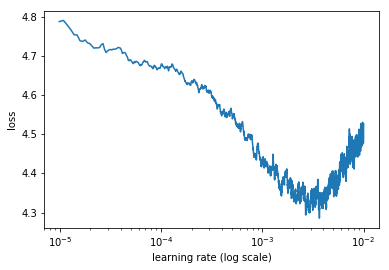

In [25]:
learner.sched.plot()

In [26]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                       
    0      4.110749   3.904749   0.335699  
    1      3.928349   3.757431   0.347719                       
    2      3.873494   3.681325   0.355097                       
    3      3.807742   3.641327   0.359189                       
    4      3.760053   3.615188   0.361798                       
    5      3.702095   3.597735   0.363792                       
    6      3.686025   3.580522   0.365967                       
    7      3.718473   3.567337   0.367381                       
    8      3.670846   3.552513   0.369238                       
    9      3.655294   3.541549   0.370362                       
    10     3.649676   3.531808   0.371712                       
    11     3.583571   3.526094   0.372884                       
    12     3.564623   3.518948   0.373758                       
    13     3.57512    3.510578   0.374749                       
    14     3.513149   3.507288   0.375246     

[array([3.50729]), 0.3752461208011776]

In [27]:
learner.save('lm1')

In [28]:
learner.save_encoder('lm1_enc')

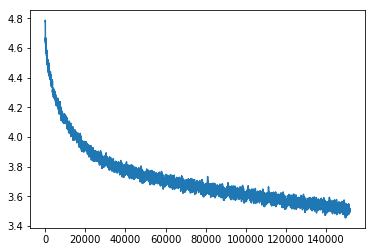

In [29]:
learner.sched.plot_loss()

## Classifier Tokens

In [9]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [10]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0


/home/salman/py36venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/salman/py36venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


1
2
3
4
5
0


In [37]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [14]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [5]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [16]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [42]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

In [59]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [60]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))
print('{}, {}'.format(len(trn_labels), len(val_labels)))

121781, 13532


In [61]:
trn_clas = trn_clas[:-1]
# val_clas = val_clas[:100]
trn_labels = trn_labels[:-1]
# val_labels = val_labels[:100]
print(len(trn_clas))

121780


In [62]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 9

In [63]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [64]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
# trn_samp = SortSampler(trn_clas, key=lambda x: len(trn_clas[x]))
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [65]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [66]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [67]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [68]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [69]:
learn.crit = partial(F.cross_entropy, weight=Variable(torch.Tensor([0.2, 0.4, 0.4]).cuda()))

In [70]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [71]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [72]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [73]:
learn.freeze_to(-1)

 72%|███████▏  | 21813/30445 [19:48<07:50, 18.36it/s, loss=2.01] 

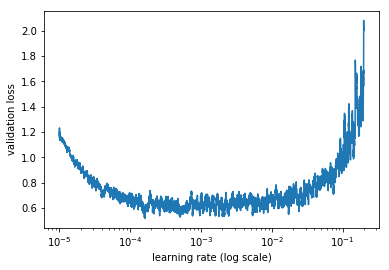

In [74]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [75]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.613945   0.460715   0.84363   


[array([0.46072]), 0.8436299234589035]

In [76]:
learn.save('clas_0_bs9_020404')

In [77]:
learn.load('clas_0_bs9_020404')

In [78]:
learn.freeze_to(-2)

In [79]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.488706   0.518101   0.874741  


[array([0.5181]), 0.8747413611353906]

In [80]:
learn.save('clas_1_bs9_020404')

In [81]:
learn.load('clas_1_bs9_020404')

In [82]:
learn.unfreeze()

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                          
    0      0.435112   0.355835   0.877328  
    1      0.470769   0.610692   0.866686                          
    2      0.373071   1.338711   0.883683                          
    3      0.455776   0.79407    0.879545                          
    4      0.458673   1.12359    0.885752                          
 11%|█▏        | 3459/30445 [07:21<57:23,  7.84it/s, loss=0.406]  

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save('clas_2_bs9_020404')

In [ ]:
learn.sched.plot_lr()

## Make predictions

In [87]:
%%time

preds, target = learn.predict_with_targs()

CPU times: user 1min 22s, sys: 21.5 s, total: 1min 44s
Wall time: 1min 43s


In [88]:
# Calcualate the inference times
time_taken = 3 * 60 + 17
time_per_sample = time_taken / len(target)
print('Time per sample: {} s'.format(time_per_sample))
print('Samples per second: {}'.format(1/time_per_sample))

Time per sample: 0.014558084540348803 s
Samples per second: 68.69035532994924


In [89]:
pred = preds.argmax(axis=1)

In [90]:
from sklearn.metrics import confusion_matrix

In [91]:
conf_mat = confusion_matrix(target, pred, labels = [0, 1, 2])

In [92]:
# funtion to plot confusion matrices, will be needed later

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)

    print(cm)
    
    
    plt.title(title)
    plt.colorbar( )
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.93843 0.05611 0.00546]
 [0.05052 0.83109 0.11839]
 [0.00585 0.08398 0.91017]]


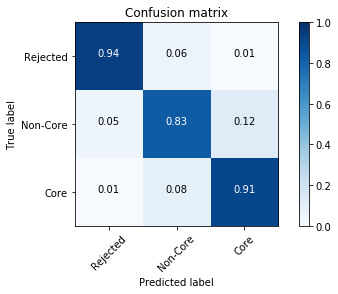

In [93]:
plt.figure()
plot_confusion_matrix(conf_mat, ['Rejected', 'Non-Core', 'Core'], normalize=True)
plt.show()